In [1]:
!pip install seaborn==0.9.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 KB 4.3 MB/s eta 0:00:002.7 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2


In [2]:
import seaborn as sns

print(sns.__version__)

0.9.0


In [3]:
!pip install graphviz==0.9
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 3.8 MB/s eta 0:00:00


In [4]:
!apt-get install graphviz

E: Não foi possível abrir arquivo de trava /var/lib/dpkg/lock-frontend - open (13: Permissão negada)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [19]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [20]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
55,76666.68,0,16,24846.60026
41,57463.74,0,15,23114.95042
42,41296.05,0,10,19485.88872
43,96446.05,0,17,38476.10072
45,64387.60,0,10,23609.01780


In [21]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [22]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [72.89, 78.67]


In [23]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [24]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [25]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.07, 79.29]


In [26]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.80
Intervalo [72.90, 78.69]


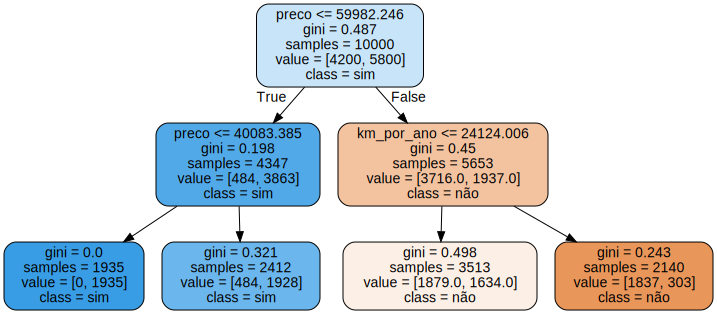

In [27]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [28]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.68
Intervalo [75.57, 81.80]


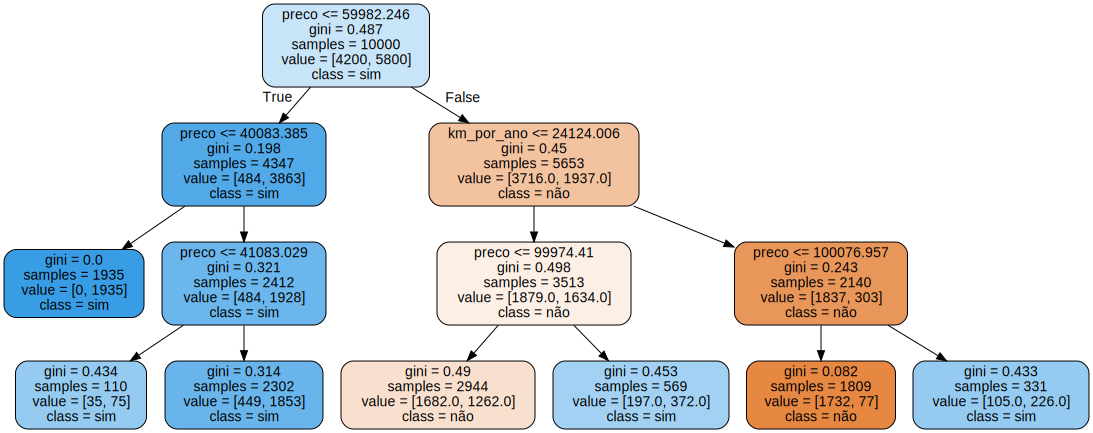

In [29]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [30]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.97
Intervalo [75.03, 78.91]


# Explorando hiper parâmetros em uma dimensão

In [31]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela
  
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.80
Arvore max_depth = 2, treino = 75.79, teste = 75.80
Arvore max_depth = 3, treino = 78.75, teste = 78.68
Arvore max_depth = 4, treino = 78.79, teste = 78.66
Arvore max_depth = 5, treino = 78.95, teste = 78.59
Arvore max_depth = 6, treino = 79.14, teste = 78.54
Arvore max_depth = 7, treino = 79.44, teste = 78.31
Arvore max_depth = 8, treino = 79.82, teste = 77.90
Arvore max_depth = 9, treino = 80.33, teste = 77.45
Arvore max_depth = 10, treino = 81.05, teste = 76.97
Arvore max_depth = 11, treino = 81.86, teste = 76.66
Arvore max_depth = 12, treino = 82.82, teste = 76.31
Arvore max_depth = 13, treino = 83.90, teste = 75.96
Arvore max_depth = 14, treino = 84.88, teste = 75.41
Arvore max_depth = 15, treino = 85.93, teste = 75.01
Arvore max_depth = 16, treino = 87.04, teste = 74.91
Arvore max_depth = 17, treino = 88.07, teste = 74.53
Arvore max_depth = 18, treino = 89.13, teste = 74.26
Arvore max_depth = 19, treino = 90.20, teste = 73.83
Ar

,max_depth,train,test
0,1,75.791308,75.795015
1,2,75.791308,75.795015
2,3,78.751166,78.683167
3,4,78.788947,78.663124
4,5,78.949014,78.591557


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

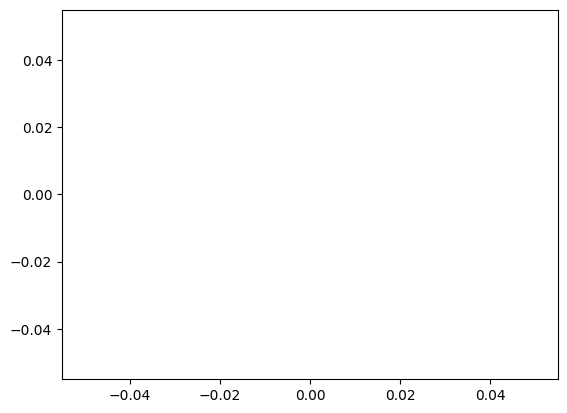

In [32]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)

# OVERFIT: ficou "perfeito" para o treino mas ruim para o teste

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

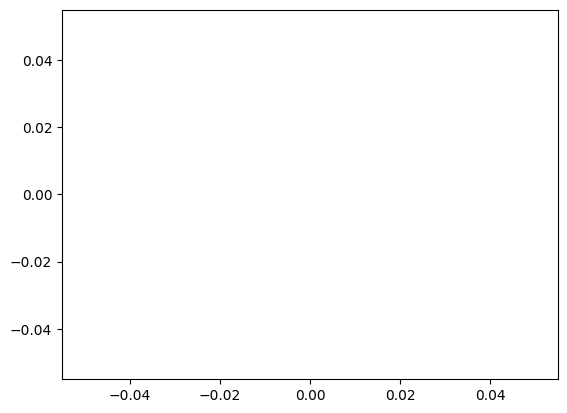

In [33]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [34]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.751166,78.683167
3,4,78.788947,78.663124
4,5,78.949014,78.591557
5,6,79.143373,78.540192
6,7,79.442263,78.314519


# Explorando hiper parâmetros em 2 dimensões

In [35]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.80
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.68
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.68
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791308,75.795015
1,1,64,75.791308,75.795015
2,1,128,75.791308,75.795015
3,1,256,75.791308,75.795015
4,2,32,75.791308,75.795015


In [36]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.751166,78.683167
19,5,256,78.751166,78.683167
10,3,128,78.751166,78.683167
8,3,32,78.751166,78.683167
13,4,64,78.751166,78.683167


In [37]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.550028,0.000774
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.406407,0.437464
train,5.500279e-01,-4.064066e-01,1.000000,0.129546
test,7.744906e-04,4.374643e-01,0.129546,1.000000


In [38]:
sns.heatmap(corr)

/home/arthur-pulini/.local/lib/python3.10/site-packages/seaborn/matrix.py:70: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros(data.shape, np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [39]:
pd.scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

AttributeError: module 'pandas' has no attribute 'scatter_matrix'

In [40]:
sns.pairplot(resultados)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [41]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/tmp/ipykernel_35320/1569857682.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros_like(corr, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [42]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.80
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.80
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.80
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.68
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.52, teste = 77.51
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.68
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791308,75.795015
1,1,192,75.791308,75.795015
2,1,256,75.791308,75.795015
3,1,512,75.791308,75.795015
4,2,128,75.791308,75.795015


In [43]:
corr = resultados.corr()

In [44]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/tmp/ipykernel_35320/1569857682.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros_like(corr, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [45]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
18,5,256,78.751166,78.683167
17,5,192,78.751166,78.683167
14,4,256,78.751166,78.683167
8,3,128,78.751166,78.683167
10,3,256,78.751166,78.683167


# Explorando 3 dimensões de hiper parâmetros

In [46]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()








,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791308,75.795015,0.003723,0.001084
1,1,32,64,75.791308,75.795015,0.003328,0.000921
2,1,32,128,75.791308,75.795015,0.003447,0.001025
3,1,32,256,75.791308,75.795015,0.003334,0.000888
4,1,64,32,75.791308,75.795015,0.003273,0.000912


In [47]:
corr = resultados.corr()


In [48]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/tmp/ipykernel_35320/1569857682.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros_like(corr, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [49]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
62,4,256,128,78.751166,78.683167,0.008329,0.001276
63,4,256,256,78.751166,78.683167,0.008360,0.001153
48,4,32,32,78.751166,78.683167,0.008446,0.001088
76,5,256,32,78.751166,78.683167,0.009512,0.001248
78,5,256,128,78.751166,78.683167,0.009814,0.001363


# Explorando espaço de hiper parâmetros com GridSearchCV

In [50]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006986,0.000351,0.001084,0.000161,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767096,...,0.818905,0.774063,0.806773,0.794147,0.771717,0.792857,0.777154,0.786832,0.01558,1
1,0.006773,0.000243,0.001082,0.000256,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767096,...,0.818905,0.774063,0.806773,0.794147,0.771717,0.792857,0.777154,0.786832,0.01558,1
2,0.006635,0.000100,0.000882,0.000021,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767096,...,0.818905,0.774063,0.806773,0.794147,0.771717,0.792857,0.777154,0.786832,0.01558,1
3,0.006627,0.000095,0.000923,0.000079,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767096,...,0.818905,0.774063,0.806773,0.794147,0.771717,0.792857,0.777154,0.786832,0.01558,1
4,0.006613,0.000105,0.000945,0.000096,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767096,...,0.818905,0.774063,0.806773,0.794147,0.771717,0.792857,0.777154,0.786832,0.01558,1


In [51]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.68316661476126


In [52]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [53]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Como ter uma estimativa sem esse vício nos dados que eu já vi?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1527, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 928, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 377, in split
    for train, test in super().split(X, y, groups):
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 108, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 120, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "/home/arthur-pulini/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 563, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


# Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [55]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006785,0.000389,0.001304,0.000207,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7825,0.7915,0.7965,0.777,0.7875,0.787,0.006797,1
1,0.006125,0.000089,0.001044,0.000178,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7825,0.7915,0.7965,0.777,0.7875,0.787,0.006797,1
2,0.006022,0.000072,0.000932,0.000041,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7825,0.7915,0.7965,0.777,0.7875,0.787,0.006797,1
3,0.006355,0.000284,0.001073,0.000251,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7825,0.7915,0.7965,0.777,0.7875,0.787,0.006797,1
4,0.006019,0.000068,0.000961,0.000047,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7825,0.7915,0.7965,0.777,0.7875,0.787,0.006797,1


In [56]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.803 , 0.7745, 0.7855, 0.785 , 0.787 ])

In [57]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [58]:
imprime_score(scores)

Accuracy médio 78.70
Intervalo [76.87, 80.53]


In [59]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


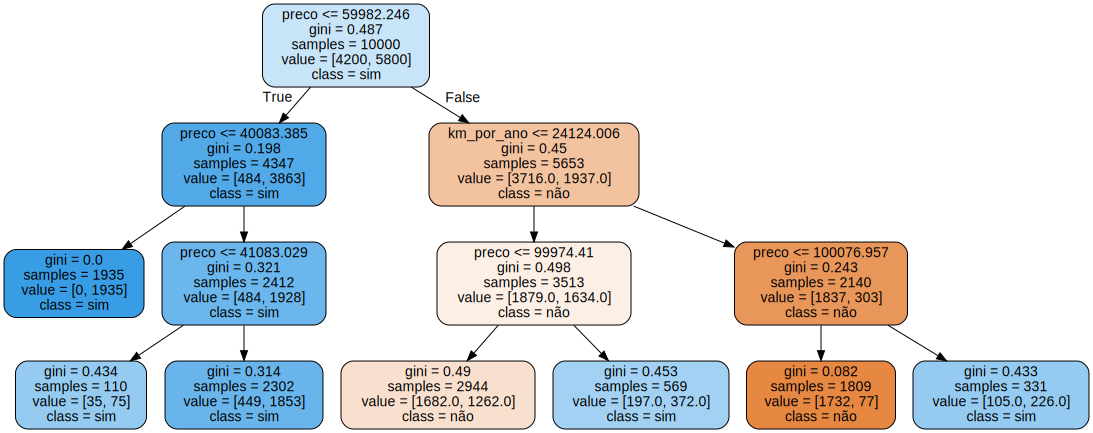

In [60]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Busca aleatória: RandomSearch

In [67]:
 from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128], 
    "criterion" : ["gini", "entropy"]
}

busca =  RandomizedSearchCV(DecisionTreeClassifier(),
                            espaco_de_parametros,
                            n_iter=16,
                            cv = KFold(n_splits = 5, shuffle=True),
                            random_state=SEED)
#Precisamos definir n_iter com o número desejado de iterações

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009537,0.000259,0.001449,0.000172,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7775,0.7915,0.7885,0.777,0.7875,0.7844,0.005987,16
1,0.006391,0.000208,0.001369,0.000263,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7825,0.7915,0.7965,0.777,0.7875,0.7870,0.006797,1
2,0.006539,0.000471,0.001252,0.000046,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7825,0.7915,0.7965,0.777,0.7875,0.7870,0.006797,1
3,0.010600,0.000645,0.001407,0.000297,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7775,0.7915,0.7935,0.777,0.7875,0.7854,0.006931,10
4,0.010324,0.000405,0.001272,0.000106,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7775,0.7915,0.7935,0.777,0.7875,0.7854,0.006931,10


In [68]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.69
Intervalo [75.93, 81.45]


In [69]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


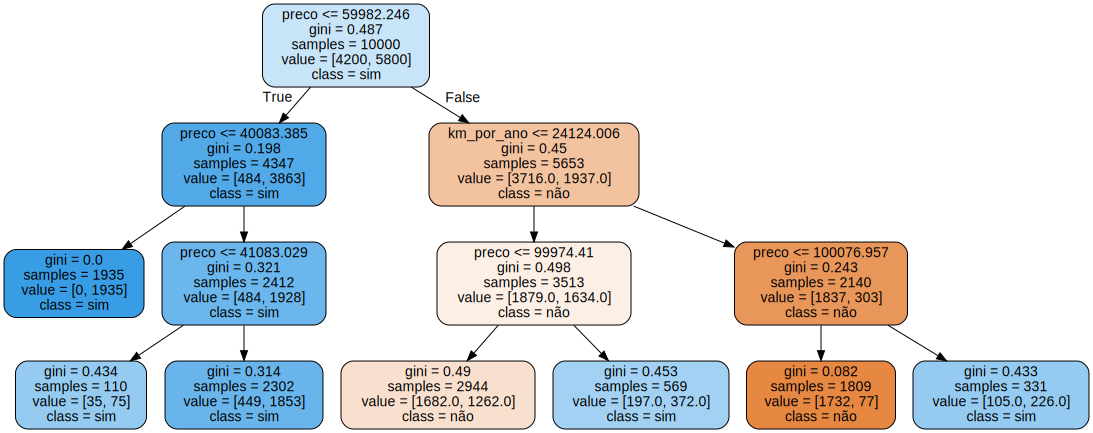

In [71]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Customizando o espaço de hiper parâmetros

In [73]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128), 
    "criterion" : ["gini", "entropy"]
}

busca =  RandomizedSearchCV(DecisionTreeClassifier(),
                            espaco_de_parametros,
                            n_iter=16,
                            cv = KFold(n_splits = 5, shuffle=True),
                            random_state=SEED)
#Precisamos definir n_iter com o número desejado de iterações

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009655,0.003566,0.001378,0.000208,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7825,0.7915,0.7965,0.7770,0.7875,0.7870,0.006797,1
1,0.012391,0.000580,0.001395,0.000235,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7790,0.7810,0.7855,0.7750,0.7855,0.7812,0.004007,9
2,0.011366,0.000166,0.001472,0.000268,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7795,0.7805,0.7845,0.7735,0.7850,0.7806,0.004152,13
3,0.014095,0.000852,0.001983,0.000232,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7720,0.7735,0.7725,0.7670,0.7720,0.7714,0.002267,16
4,0.011322,0.000477,0.001278,0.000065,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7795,0.7805,0.7845,0.7735,0.7850,0.7806,0.004152,13


In [74]:
 scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.69
Intervalo [75.93, 81.45]


In [75]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


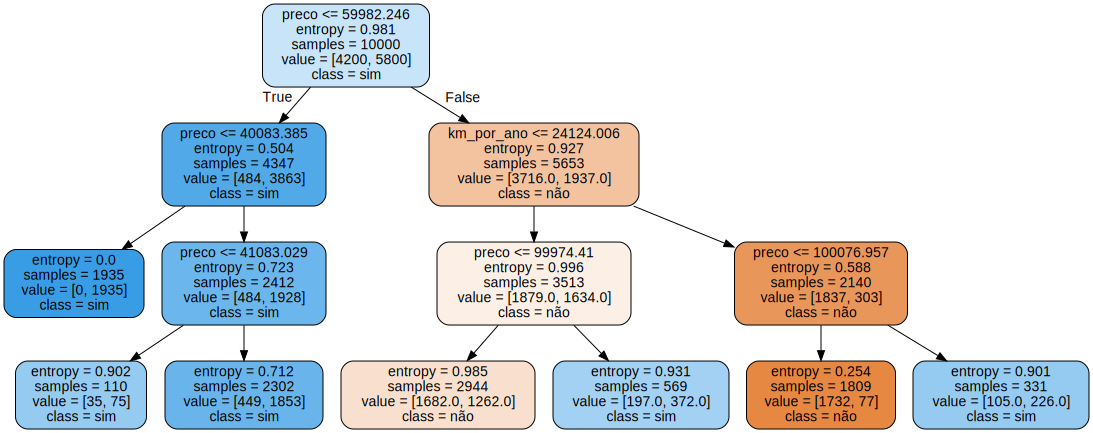

In [76]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph